In [ ]:
!pip install datasets
!pip install torch torchvision torchaudio
!pip install transformers
!pip install rouge-score nltk
!pip install sentencepiece
!pip install evaluate

In [ ]:
import nltk
nltk.download('punkt')

In [3]:
from datasets import load_dataset, load_metric
from transformers import (
    DataCollatorForSeq2Seq,
    MT5ForConditionalGeneration,
    MT5Tokenizer,
    pipeline,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
) 
import evaluate
import numpy as np
import datasets

In [4]:
tokenizer = MT5Tokenizer.from_pretrained("google/mt5-small")  # cointegrated/rut5-small google/mt5-small
model = MT5ForConditionalGeneration.from_pretrained('google/mt5-small')

# tokenizer = MT5Tokenizer.from_pretrained("results/checkpoint-121500")  # это если мы хотим подгрузить веса модели которую уже обучали
# model = MT5ForConditionalGeneration.from_pretrained('results/checkpoint-121500')

In [5]:
max_target_tokens_count = 128
max_source_tokens_count = 1024


def preprocess_function(examples):
    print(examples['text'][0])
    inputs = examples["text"]
    model_inputs = tokenizer(inputs, max_length=max_source_tokens_count, truncation=True)

    labels = tokenizer(text_target=examples["summary"], max_length=max_target_tokens_count, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    
    return model_inputs

In [ ]:
dataset = load_dataset('IlyaGusev/gazeta',revision="v2.0")
tokenized_dataset = dataset.map(preprocess_function, batched=True)

In [7]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [ ]:
rouge = load_metric("rouge")
bleu = evaluate.load("bleu")

In [9]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    result = {}
    result_rouge = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    # Extract a few results
    result.update({key: value.mid.fmeasure * 100 for key, value in result_rouge.items()})
    
    result_bleu = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    # Extract a few results
    result["bleu"] = result_bleu["bleu"] * 100
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    result["char_len"] = np.mean([len(t) for t in decoded_preds])
    
    return {k: round(v, 4) for k, v in result.items()}

In [10]:
training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/NLP/results",
    evaluation_strategy="steps",
    eval_steps=25,
    logging_steps=25,
    learning_rate=4e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=64,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    fp16=False,
    predict_with_generate=True,
    generation_max_length=max_target_tokens_count,
    generation_num_beams=5
)

In [11]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [172]:
trainer.place_model_on_device

True

In [12]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `MT5ForConditionalGeneration.forward` and have been ignored: text, url, summary, title, date. If text, url, summary, title, date are not expected by `MT5ForConditionalGeneration.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 60964
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 64
  Total optimization steps = 238
  Number of trainable parameters = 300176768
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] =

Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Bleu,Gen Len,Char Len
25,6.708300,2.790221,5.617400,1.639000,5.514300,5.542900,1.428500,33.347000,120.156900
50,3.641800,2.622362,8.640000,2.712500,8.374600,8.472800,2.731000,37.947900,139.983800
75,3.308900,2.532011,12.533000,4.017900,12.186400,12.313300,4.091000,54.395700,193.506300
100,3.178000,2.467763,15.328000,5.053200,15.016500,15.094800,5.401300,75.787900,263.415600
125,3.088000,2.437126,16.088800,5.370100,15.738600,15.820500,5.722000,78.585300,272.553700
150,3.050200,2.421197,16.381400,5.186200,16.058300,16.153600,6.044100,84.006300,291.502900
175,3.008400,2.402808,16.253000,5.152000,15.895000,16.039900,5.999700,81.600600,283.620100
200,2.981000,2.396950,16.214800,5.278400,15.883500,15.998000,6.202700,84.891800,295.519200
225,2.981800,2.390809,16.208200,5.176000,15.876900,16.007100,6.259400,85.995700,299.261600


The following columns in the evaluation set don't have a corresponding argument in `MT5ForConditionalGeneration.forward` and have been ignored: text, url, summary, title, date. If text, url, summary, title, date are not expected by `MT5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 6793
  Batch size = 4
The following columns in the evaluation set don't have a corresponding argument in `MT5ForConditionalGeneration.forward` and have been ignored: text, url, summary, title, date. If text, url, summary, title, date are not expected by `MT5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 6793
  Batch size = 4
The following columns in the evaluation set don't have a corresponding argument in `MT5ForConditionalGeneration.forward` and have been ignored: text, url, summary, title, date. If text, url, summary, title, date are not expected by `MT5ForCondi

TrainOutput(global_step=238, training_loss=3.518548099934554, metrics={'train_runtime': 27088.001, 'train_samples_per_second': 2.251, 'train_steps_per_second': 0.009, 'total_flos': 6.443062421704704e+16, 'train_loss': 3.518548099934554, 'epoch': 1.0})

In [13]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `MT5ForConditionalGeneration.forward` and have been ignored: text, url, summary, title, date. If text, url, summary, title, date are not expected by `MT5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 6793
  Batch size = 4


{'eval_loss': 2.391138792037964,
 'eval_rouge1': 16.2645,
 'eval_rouge2': 5.222,
 'eval_rougeL': 15.9174,
 'eval_rougeLsum': 16.057,
 'eval_bleu': 6.245,
 'eval_gen_len': 86.092,
 'eval_char_len': 299.729,
 'eval_runtime': 3006.5045,
 'eval_samples_per_second': 2.259,
 'eval_steps_per_second': 0.565,
 'epoch': 1.0}

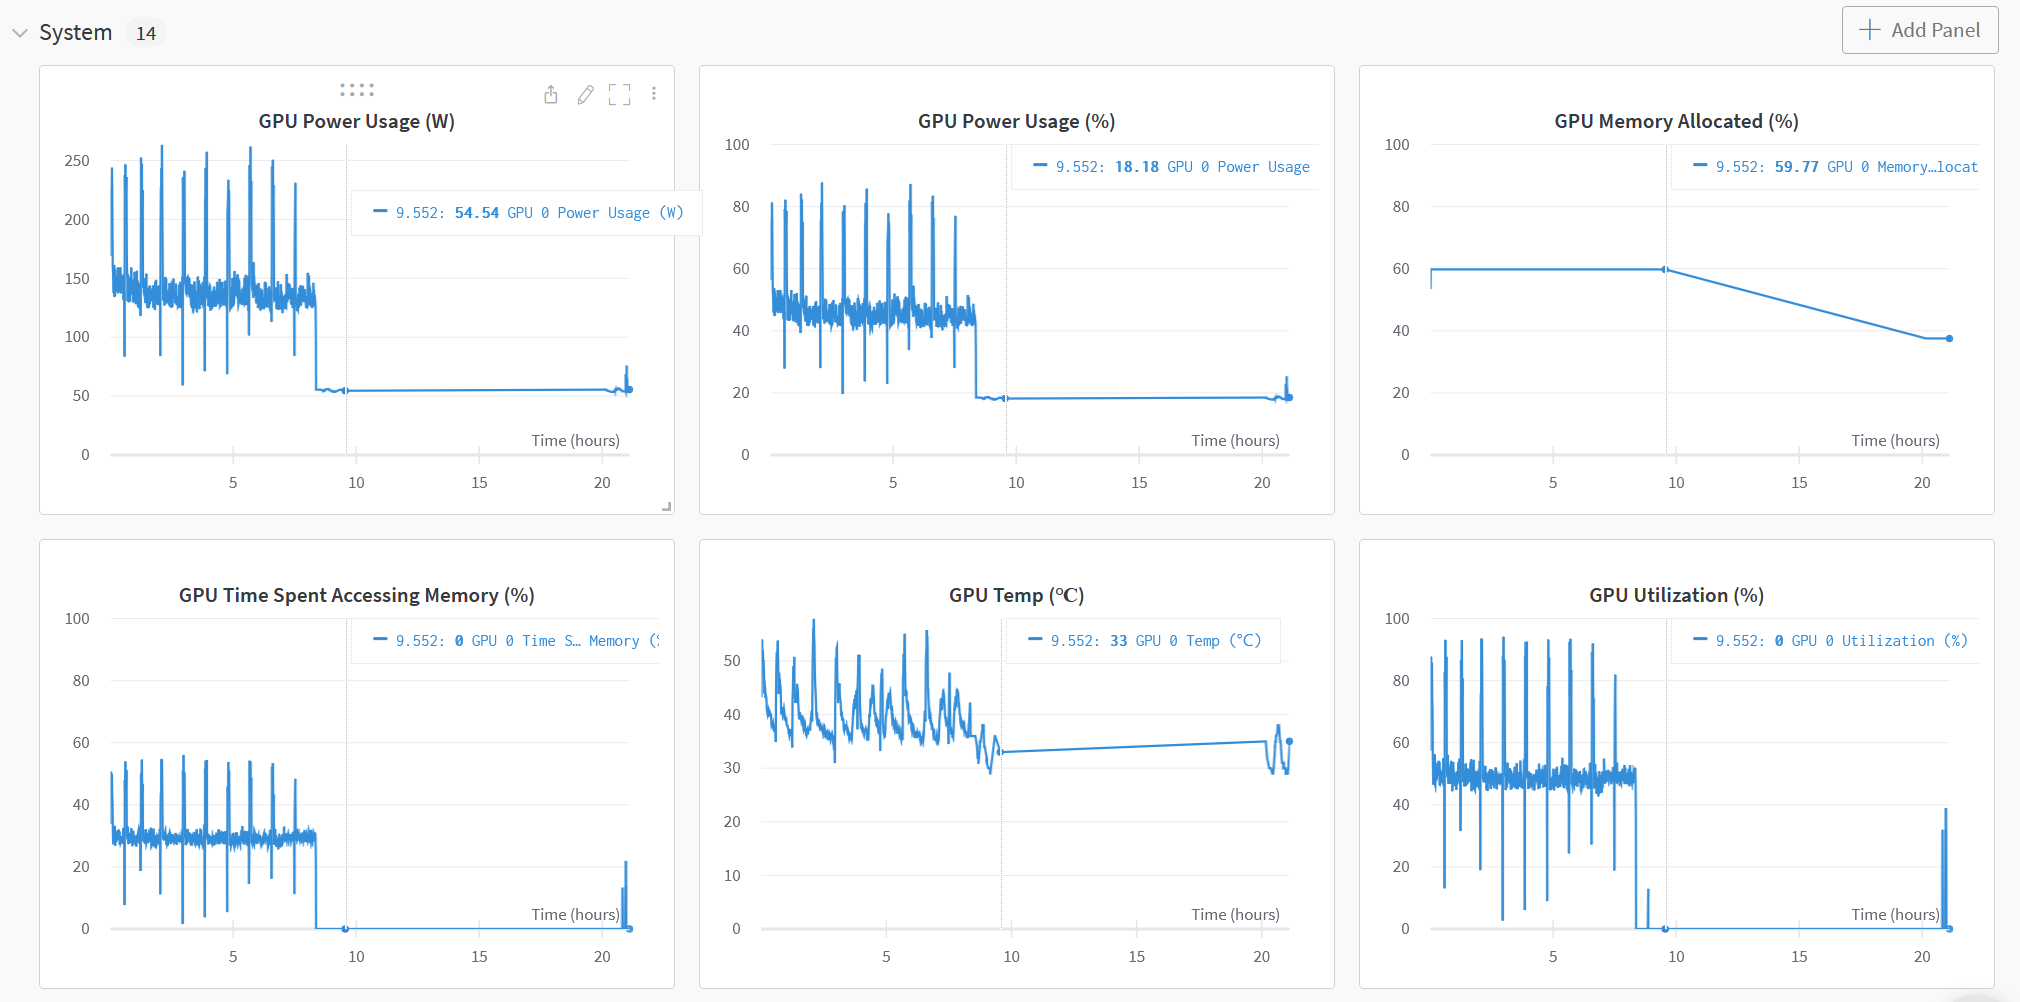

In [14]:
# суммаризованные тексты можно достать с помощью
# https://huggingface.co/docs/transformers/v4.24.0/en/main_classes/pipelines#transformers.SummarizationPipeline

In [86]:
# summarizer = pipeline("summarization", model=model.to('cpu'), tokenizer=tokenizer)  # плохо работает, сильно обрезает, что-то не так делает

In [94]:
pwd

'/usr/src/app/NLP/lab4'

In [95]:
trainer.save_model(output_dir='/usr/src/app/NLP/lab4/model')

Saving model checkpoint to /usr/src/app/NLP/lab4/model
Configuration saved in /usr/src/app/NLP/lab4/model/config.json
Model weights saved in /usr/src/app/NLP/lab4/model/pytorch_model.bin
tokenizer config file saved in /usr/src/app/NLP/lab4/model/tokenizer_config.json
Special tokens file saved in /usr/src/app/NLP/lab4/model/special_tokens_map.json


In [96]:
trained_tokenizer = MT5Tokenizer.from_pretrained("/usr/src/app/NLP/lab4/model")  # это если мы хотим подгрузить веса модели которую уже обучали
trained_model = MT5ForConditionalGeneration.from_pretrained('/usr/src/app/NLP/lab4/model')

loading file spiece.model
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file /usr/src/app/NLP/lab4/model/config.json
Model config MT5Config {
  "_name_or_path": "google/mt5-small",
  "architectures": [
    "MT5ForConditionalGeneration"
  ],
  "d_ff": 1024,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "mt5",
  "num_decoder_layers": 8,
  "num_heads": 6,
  "num_layers": 8,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "tokenizer_class": "T5Tokenizer",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "use_cache": true,
  "vocab_size": 250112
}

loading

In [160]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def summarize(model, tokenizer, text):
    preprocess_text = text.strip().replace("\n","")
    tokenized_text = tokenizer.encode(preprocess_text, return_tensors="pt").to(device)

    summary_ids = model.generate(
                tokenized_text,
                max_length=150, 
                num_beams=2,
                repetition_penalty=2.5, 
                length_penalty=1.0, 
                early_stopping=True
            )

    output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    print ("Summarized text: \n",output)
device    

device(type='cuda', index=0)

In [161]:
trained_model = trained_model.to(device)

In [185]:
str(dataset.data['train']['text'][0])

'Сегодня транспортный налог начисляется в зависимости от мощности автомобиля, причем цена для «сильных» машин выше, чем для малолитражек. Также ставку налога могут корректировать региональные власти: согласно Налоговому кодексу, базовый тариф, установленный правительством, может быть уменьшен в пять раз или увеличен до 10 раз. Сборы идут в региональные бюджеты, откуда растекаются на общие нужды. Транспортный налог — один из основных источников бюджетных доходов — предлагается направить исключительно на дорожные фонды. Так, автомобилисты будут понимать, за что они платят, а дорожники будут иметь гарантированный доход. Кроме налога дорожные фонды будут пополняться за счет бюджетных средств и проезда по платным дорогам. Более того, транспортный налог предлагается завуалировать в акцизы на бензин. Привычную и раздражающую систему ежегодной оплаты квитанции предлагается изменить, включив налог в стоимость топлива. Минэкономразвития говорит об удвоении акцизы, которая сегодня составляет 3,32

In [162]:
text = str(dataset.data['train']['text'][0])
summarize(trained_model, trained_tokenizer, text)

Summarized text: 
 Власти рассчитывают собирать до 62 млрд рублей в год, а дорожники будут платить за дороги. При этом налоговые органы присылают квитанцию на бензин.


In [187]:
str(dataset.data['train']['text'][5000])

'В понедельник в Хамовническом суде Москвы началось оглашение приговора по второму уголовному делу в отношении экс-главы ЮКОСа Михаила Ходорковского и бывшего руководителя МФО МЕНАТЕП Платона Лебедев а. Это была вторая попытка судьи Виктора Данилкин а: сначала заседание было назначено на 15 декабря, но еще до начала перенесено без объяснения причины. Вероятность переноса существовала и в понедельник, но сочувствующие начали собираться к зданию суда с 7 утра — за три часа до времени, назначенного судьей Данилкиным. К девяти, когда открылся суд, возле его входа собралась большая толпа, состоявшая из журналистов, постоянных посетителей процесса и любопытных. Адвокаты с трудом сумели провести в здание родственников подсудимых. Впрочем, в зал попали не все: как сообщили в пресс-центре Ходорковского и Лебедева, сын экс-главы МЕНАТЕПа не сумел пройти даже в здание суда. Приставы вначале пытались уговорить пришедших не напирать, потом начали силой оттирать граждан от двери, а когда и это не по

In [163]:
text = str(dataset.data['train']['text'][5000])
summarize(trained_model, trained_tokenizer, text)

Summarized text: 
 В Хамовническом суде Москвы началось оглашение приговора по второму уголовному делу в отношении экс-главы ЮКОСа Михаила Ходорковского и бывшего руководителя МФО МЕНАТЕП Платона Лебедева. По словам судьи, это была вторая попытка судьи Виктора Данилкина.


In [170]:
str(dataset.data['train']['text'][60963])

'Несмотря на приближение Нового года, последние два дня президент Белоруссии Александр Лукашенко занимался не только подготовкой к празднику. 30 и 31 декабря он провел телефонные переговоры с президентом РФ Владимиром Путиным, а также созвонился с российским премьером Дмитрием Медведевым и главой Минэнерго РФ Александром Новаком. И судя, по официальным заявлениям, все было не зря. Ему удалось добиться от Москвы по крайней мере временного решений по вопросу поставок нефти в страну. Поставки российской нефти не прекратятся в 2020 году, но будут происходить в Белоруссию без контрактов, по договоренности для каждого отдельного предприятия. «Рабочие вопросы были обсуждены в продолжение переговоров с Владимиром Путиным, а также в связи с тем, что контрактов, регламентирующих работу в нефтегазовой сфере, на 1 января не заключено. Итогом разговора стала договоренность об организации конкретной работы по поставкам углеводородного сырья в Белоруссию», — говорится в официальном сообщении президен

In [168]:
text = str(dataset.data['train']['text'][60963])
summarize(trained_model, trained_tokenizer, text)

Summarized text: 
 В Белоруссии Александр Лукашенко занимался не только подготовкой к празднику, но также созвонился с российским премьером Дмитрием Медведевым и главой Минэнерго РФ Александром Новаком. По словам президента Белоруссии Владимира Путина, в последние два дня он провел телефонные переговоры с президентом РФ Владимиром Путиным.


In [173]:
text = """Российские власти подготовили список мер в ответ на введение потолка цен на экспортируемую из РФ нефть. С проектом соответствующего президентского указа ознакомились «Ведомости».

Из документа, в частности, следует, что будет запрещена продажа нефти при следующих условиях:

    Если в контракте в качестве получателя указана страна, присоединившаяся к потолку;
    Если в контракте потолок фигурирует как условие, либо устанавливаются референтные цены, равные потолку (его установили на отметке 60 долларов за баррель).

Кроме того, в проекте указа также есть пункт, позволяющий с разрешения правительства обходить любые запреты на проведение сделок, пишут «Ведомости».

Действие указа не будет распространяться на соглашения, заключенные до 5 декабря — с этого дня действует потолок цен на нефть.

Предполагается, что указ вступит в силу с момента опубликования и будет действовать до 1 июля следующего года с возможностью продления.

Детали реализации указа, в частности, порядок мониторинга за соблюдением запрета, список стран, в отношении которых будут действовать прописанные в документе меры, должно будет определить правительство.

Источники «Ведомостей» заявили, что работа над проектом указа еще не завершена. Официальные лица, а также представители крупнейших компаний — экспортеров нефти, на запрос издания о комментариях на момент публикации статьи не ответили.

Пресс-секретарь президента РФ Дмитрий Песков 12 декабря сообщил, что текст указа об ответных мерах на потолок цен на российскую нефть будет опубликован «в ближайшие дни». 

Потолок цен на российскую нефть установлен на уровне 60 долларов за баррель. После 15 января его будут регулярно пересматривать. Новый уровень должен быть как минимум на 5% ниже, чем стоимость российской нефти на мировых рынках.

Власти РФ неоднократно заявляли, что не будут поставлять нефть в страны, поддержавшие введение потолка цен. К ним относятся страны «Большой семерки», страны — члены Евросоюза и Австралия. Покупать российскую нефть дороже установленной цены смогут Венгрия, Болгария, Словакия, Чехия и Хорватия.
"""
summarize(trained_model, trained_tokenizer, text)


Summarized text: 
 В ближайшие дни будут запрещена продажа нефти. Потолок цен на российскую нефть будет опубликован «в ближайшие дни».Российские власти подготовили список мер в ответ на введение потолка цен на экспортируемую из РФ нефть.


In [209]:
text = """ "В результате принятых мер в текущем году на стадии приготовления предотвращено 123 преступления террористической направленности, в том числе 64 теракта. Пресечена деятельность 68 законспирированных ячеек международных террористических организаций", - сообщили в НАК.

Кроме того, отметили в НАК, выявлено около 2,6 тыс. фактов незаконного оборота оружия, ликвидировано более 50 подпольных оружейных мастерских, пресечена деятельность 74 организованных преступных групп, занимавшихся изготовлением средств поражения. Также значительно сокращено ресурсное обеспечение террористов, заблокированы счета около 3 тыс. граждан, причастных к финансированию терроризма, на общую сумму свыше 94 млн рублей.
"""

In [210]:
summarize(trained_model, trained_tokenizer, text)

Summarized text: 
 В результате приготовления предотвращено 123 преступления террористической направленности, в том числе 64 теракта. Пресечена деятельность 68 законспирированных ячеек международных террористических организаций.


In [205]:
text = """Еву Кайли задержали 9 декабря. Ее и еще нескольких чиновников обвиняют в получении от Катара взятки в обмен на улучшение имиджа этой страны в Европе в преддверии ЧМ по футболу. На своем посту бывшая журналистка отвечала за связи с Ближним Востоком, а также была членом экономического комитета по расследованию коррупции в ЕС. Она имела доступ к секретным документам и закрытым информационным базам. Свою вину Ева Кайли не признает. """

In [206]:
summarize(trained_model, trained_tokenizer, text)

Summarized text: 
 В Европе Ева Кайли задержали 9 декабря. Ее и еще несколько чиновников обвиняют в получении от Катара взятки в обмен на улучшение имиджа этой страны в преддверии ЧМ по футболу.


In [201]:
text = """

Об этом «Газете.Ru» рассказали  в пресс-службе Банка России. В третьем квартале 2022 года Центробанк обнаружил 558 компаний, выдающих займы более чем под 2000% годовых и использующих незаконные методы возврата долга. Это на 13% больше показателя второго квартала и втрое больше, чем в первом квартале.

«Количество «черных кредиторов» традиционно увеличивается на фоне экономической неопределенности», — отметили в пресс-службе ЦБ.

По данным регулятора, более 40% выявленных нелегальных кредиторов действовали только через интернет, более 85% — рекламировали свои услуги через социальные сети, включая платформы объявлений. Всего за девять месяцев 2022-го Банк России выявил 1200 «черных кредиторов», почти вдвое больше аналогичного показателя прошлого года."""

In [202]:
summarize(trained_model, trained_tokenizer, text)

Summarized text: 
 В третьем квартале 2022 года Центробанк обнаружил 558 компаний, выдающих займы более чем под 2000% годовых и использующих незаконные методы возврата долга. Банк России выявил 1200 «черных кредиторов», почти вдвое больше аналогичного показателя второго квартала.


In [197]:
text = """«Сумму собрали за два дня»: подписчики подарили IPhone мальчику-пастуху из Казахстана, снявшему трогательное видео об одиночестве 

Тойбек Саят, который ведет TikTok-блог о своей жизни в ауле, прославился в соцсетях благодаря видео об одиночестве в свой день рождения. После публикации организация Charity_KZ подарила ему IPhone 12, на который, как рассказала «Газете.Ru» ее основатель Альбина Мажит, собрали деньги благодаря репостам в соцсетях всего за 2 дня.

«Оказывается, он ждал своих родных, что они его поздравят. Он был расстроен, и мы обещали, что отправим ему подарок, но не говорили какой. Мы хотели ему помочь деньгами, но решили, что это уменьшит его мотивацию. Поэтому решили помочь увеличить его просмотры, чтобы он потом мог на блоге зарабатывать. Когда получил подарок, был безудержно счастлив, несколько раз обнимал подругу, которая вручала», — сказала она.

Альбина добавила, что сбор средств запустил «цепь добрых дел» — от скидки на телефон до бесплатной доставки подарка. """

In [198]:
summarize(trained_model, trained_tokenizer, text)

Summarized text: 
 В соцсетях подписчики подарили IPhone мальчику-пастуху из Казахстана, снявшему трогательное видео об одиночестве в свой день рождения Альбину Мажит, который ведет TikTok-блог о своей жизни в ауле, прославился в соцсетях благодаря видео об одиночестве.


In [215]:
text = """«Мы сами себе создадим эволюционного конкурента»: аналитик МФТИ рассказал об опасности сильного искусственного интеллекта

Главный аналитик Центра искусственного интеллекта Московского физико-технического института Игорь Пивоваров обсудил с «Газетой.Ru» проблемы, которые стоят перед учеными. Например, создать настоящий ИИ можно, только сделав в нем личность, но тем самым человечество создает для себя экзистенциальные риски.

«Когда появится сильный ИИ, то по сравнению с ним человек окажется эволюционно отставшим. Мы сами себе создадим эволюционного конкурента. Хотя множество исследователей такую возможность отрицают, на мой взгляд риск существует», — объяснил эксперт.

Пивоваров рассказал, что в некоторых системах уже есть зачатки личности, например, в библиотеке DeepPavlov – после персонификации у робота можно даже взять интервью. По мнению ученого, со временем ИИ может вытеснить бухгалтеров, операторов станков, колл-центров и джуниор-программистов. """

In [216]:
summarize(trained_model, trained_tokenizer, text)

Summarized text: 
 В Московском физико-техническом институте Игорь Пивоваров рассказал об опасности сильного искусственного интеллекта. По мнению ученого, создать настоящий ИИ можно, только сделав в нем личность.
